<a href="https://colab.research.google.com/github/arashsajjadi/Hyper-parameter-optimization/blob/main/Raytune_based_second_edition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
pip install featurewiz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,  TensorDataset, Dataset
import torch.nn.functional as F
from ray import tune
import os
import ray
from ray.tune.schedulers import ASHAScheduler
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
#from torchmetrics import ConfusionMatrix
#confmat = ConfusionMatrix(num_classes=2)
from sklearn.metrics import balanced_accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_auc_score

In [101]:
#read data
initial_targets=pd.read_csv("bbbp.csv")
initial_features=pd.read_csv("bbbp_global_cdf_rdkit.csv")

initial_features=initial_features.loc[:, (initial_features != initial_features.iloc[0]).any()] 

shuffled_targets=initial_targets.sample(frac=1,random_state=1234).reset_index(drop=True)
shuffled_features=initial_features.sample(frac=1,random_state=1234).reset_index(drop=True)
#shuffling the data to randomize the sequence

X_train, X_test, y_train, y_test = train_test_split(shuffled_features,shuffled_targets["p_np"],test_size=0.1, random_state=1234, stratify=shuffled_targets["p_np"])
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.22, random_state=1234, stratify=y_train)

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
You supplied outputs = features
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (1431, 186)
    Loaded train data. Shape = (1431, 186)
    Some column names had special characters which were removed...
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#################

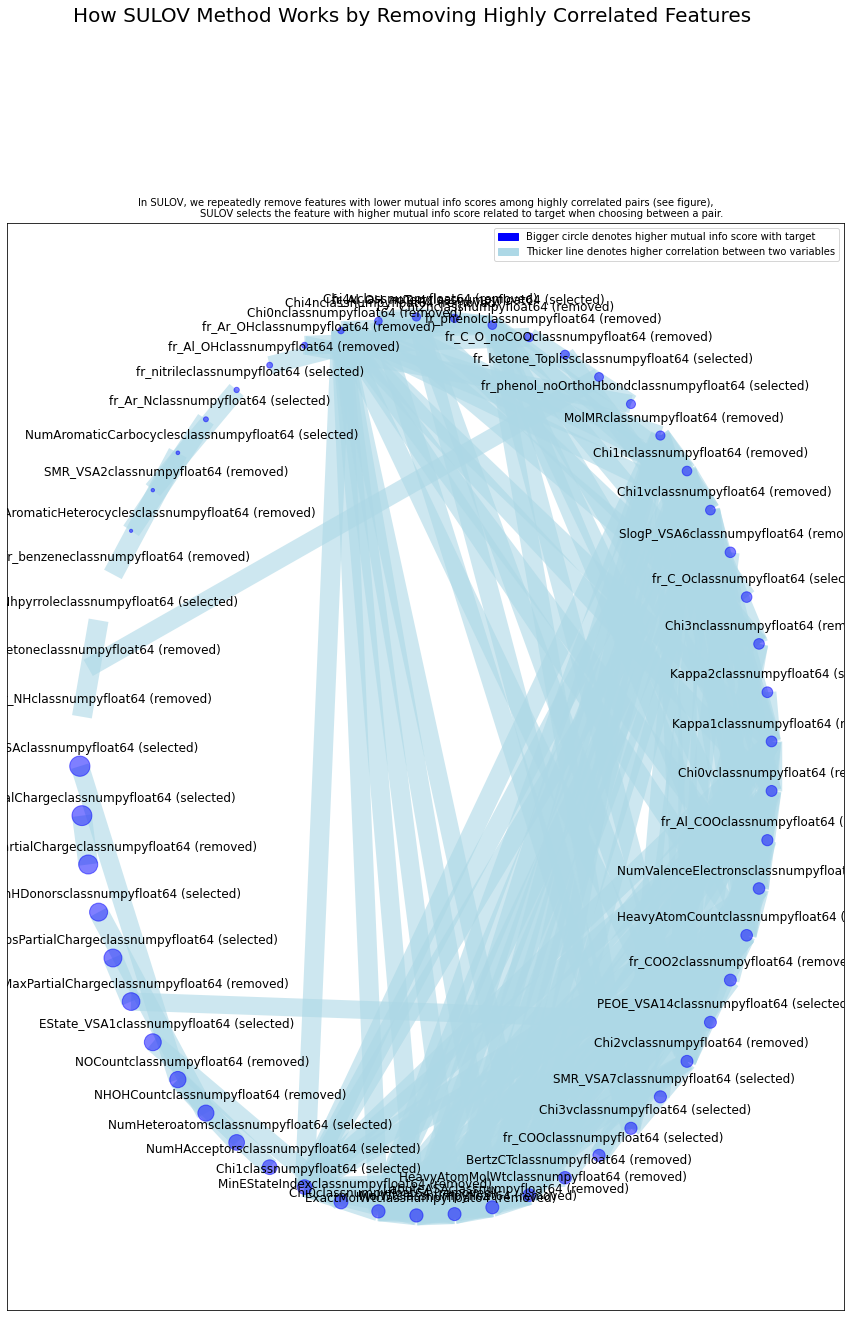

Time taken for SULOV method = 2 seconds
    Adding 0 categorical variables to reduced numeric variables  of 149
Final list of selected vars after SULOV = 149
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 149 
    XGBoost version: 1.6.1
Number of booster rounds = 100
        using 149 variables...
            Time taken for regular XGBoost feature selection = 2 seconds
        using 119 variables...
            Time taken for regular XGBoost feature selection = 6 seconds
        using 89 variables...
            Time taken for regular XGBoost feature sele

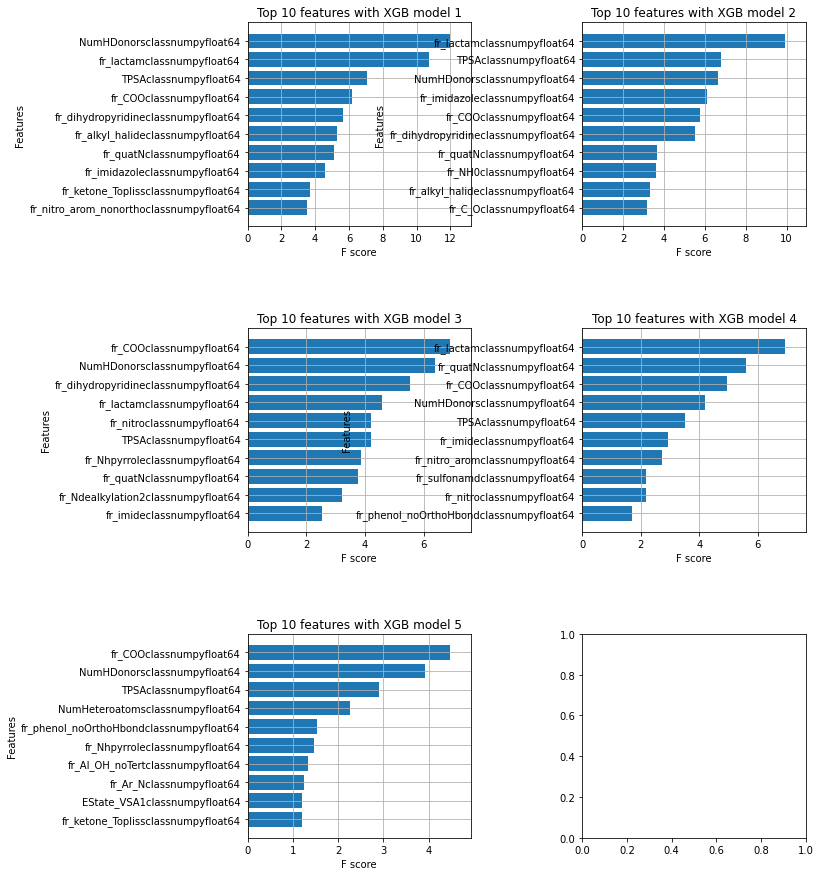

            Total time taken for XGBoost feature selection = 15 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 65 important features. Too many to print...

    Time taken for feature selection = 17 seconds
Returning 2 dataframes: dataname and test_data with 65 important features.


In [102]:
Data=pd.concat([X_train, y_train], axis=1) #reshape data for featurewiz feature selection
target = ['p_np']
from featurewiz import featurewiz 
feature_selection = featurewiz(Data, target, corr_limit=0.9, verbose=2,header=0, nrows=None,outputs="features")

In [103]:
X_train=X_train[feature_selection[0]]
X_valid=X_valid[feature_selection[0]]
X_test=X_test[feature_selection[0]]
y_train=pd.DataFrame(data=y_train)
y_valid=pd.DataFrame(data=y_valid)
y_test=pd.DataFrame(data=y_test)

In [104]:
class BbbpDataset_train (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_train.to_numpy().astype("float32")
        self.y=y_train.to_numpy().astype("float32")
        self.n_samples=X_train.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class BbbpDataset_valid (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_valid.to_numpy().astype("float32")
        self.y=y_valid.to_numpy().astype("float32")
        self.n_samples=X_valid.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class BbbpDataset_test (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_test.to_numpy().astype("float32")
        self.y=y_test.to_numpy().astype("float32")
        self.n_samples=X_test.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples
    
class ToTensor():
    def __call__(self,sample):
        inputs,targets=sample
        inputs=torch.from_numpy(inputs.astype("float32"))
        targets=torch.tensor(targets.astype("float32"))
        #targets=targets.view(targets.shape[0],1)
        return inputs,targets

#training set ---------------------------------------------------
training_set = BbbpDataset_train(transform=ToTensor())    
train_loader = DataLoader(dataset=training_set,
                          batch_size=64,
                          shuffle=True)

dataiter_train = iter(train_loader)
data_train = dataiter_train.next()


def trainloader(config):
    return  DataLoader(dataset=training_set,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
#validation set ---------------------------------------------------
validation_set = BbbpDataset_valid(transform=ToTensor())    
valid_loader = DataLoader(dataset=validation_set,
                          batch_size=64,
                          shuffle=True)

dataiter_valid = iter(valid_loader)
data_valid = dataiter_valid.next()

def validloader(config):
    return  DataLoader(dataset=validation_set,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
#test set ---------------------------------------------------
test_set = BbbpDataset_test(transform=ToTensor())    
test_loader = DataLoader(dataset=test_set,
                          batch_size=8,
                          shuffle=False)

dataiter_test = iter(test_loader)
data_test = dataiter_test.next()

def testloader(config):
    return  DataLoader(dataset=test_set,
                          batch_size=4,
                          shuffle=False,num_workers=2)

In [105]:
from sklearn.metrics import roc_auc_score

def compute_score(model, data_loader, device="cpu"):
    model.eval()
    metric = roc_auc_score
    with torch.no_grad():
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        for i, (feats, labels) in enumerate(data_loader):
            feats=feats.to(device)
            labels=labels.to(device)
            prediction = model(feats).to(device)
            prediction = torch.sigmoid(prediction).to(device)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)                
        try:
            t = metric(labels_all.int().cpu(), prediction_all.cpu()).item()
        except ValueError:
            t = 0
    return t

In [106]:
n_samples,n_features=X_train.shape
class NeuralNetwork (nn.Module):
    def __init__(self,n_input_features,l1, l2,l3):
        super (NeuralNetwork, self).__init__()
        self.linear1=nn.Linear(n_input_features,4*math.floor(n_input_features/2)+l1)
        self.linear2=nn.Linear(l1+4*math.floor(n_input_features/2),math.floor(n_input_features/2)+l2)
        self.linear3=nn.Linear(math.floor(n_input_features/2)+l2,math.floor(n_input_features/3)+l3)
        self.linear4=nn.Linear(math.floor(n_input_features/3)+l3,math.floor(n_input_features/6))
        self.linear5=nn.Linear(math.floor(n_input_features/6),1)
    def forward(self,x):
        out=torch.relu (self.linear1(x))
        out=torch.relu(self.linear2(out))
        out=torch.relu(self.linear3(out))
        out=torch.tanh(self.linear4(out))
        out=torch.sigmoid(self.linear5(out))
        y_predicted=out
        return y_predicted

In [107]:
def train_Bbbp(config,checkpoint_dir=None):
    net = NeuralNetwork(np.shape(feature_selection[0])[0],config["l1"],config["l2"],config["l3"])
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    #
    criterion=nn.BCELoss()
    optimizer=torch.optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    
    
    # The `checkpoint_dir` parameter gets passed by Ray Tune when a checkpoint
    # should be restored.
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader(config), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss / epoch_steps))
                running_loss = 0.0
    
        #Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(validloader(config), 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1


        # Validation score
        score = compute_score(net, validloader(config), device="cpu")
        #loss = criterion(outputs, labels)

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
        tune.report(loss=(val_loss / val_steps),score=score)

        #  print(f'the correct is {correct:.2f}, total is {total:.2f}, loss = {loss:.2f} , roc_auc_score={roc_auc_score(labels_val,out_val):6f}')
        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and will potentially be passed as the `checkpoint_dir`
        # parameter in future iterations.
        
        #with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
        #    path = os.path.join(checkpoint_dir, "checkpoint")
        #    torch.save(
        #        (net.state_dict(), optimizer.state_dict()), path)

        #tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")
    #print(score)

In [108]:
def test_best_model(best_trial):
    best_trained_model = NeuralNetwork(np.shape(feature_selection[0])[0],best_trial.config["l1"],best_trial.config["l2"],best_trial.config["l3"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_trial.checkpoint.value, "checkpoint")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    #trainset, testset = load_data()

    #testloader = torch.utils.data.DataLoader(
    #    testset, batch_size=4, shuffle=False, num_workers=2)

    #correct = 0
    #total = 0
    #with torch.no_grad():
    #    for data in test_loader:
    #        features, labels = data
    #        features, labels = features.to(device), labels.to(device)
    #        outputs = best_trained_model(features)
    #        _, predicted = torch.max(outputs.data, 1)
    #        total += labels.size(0)
    #        correct += (predicted == labels).sum().item()

    with torch.no_grad():
      test_score = compute_score(best_trained_model, testloader(config), device)
    print("Best trial test set score: {}".format(test_score))

   # print("Best trial test set accuracy: {}".format(correct / total))

In [119]:
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
    "l3": tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([ 16, 32, 64, 128]),
}

In [120]:
def main(num_samples=10, max_num_epochs=100, gpus_per_trial=2):
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 8)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 8)),
        "l3": tune.sample_from(lambda _: 2**np.random.randint(2, 8)),
        "lr": tune.loguniform(1e-4, 1e-1),
        #"a1"
        #"a2"
        #"a3": tune.choice(["relu", "tanh"])
        #In the next version, I will try to add the activator function to the config. I will also ask the teacher about other parameters.
        "batch_size": tune.choice([ 16, 32, 64, 128])
    }
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    result = tune.run(
        tune.with_parameters(train_Bbbp),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        metric="loss",
        mode="min",
        num_samples=num_samples,
        scheduler=scheduler
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["score"]))

    if ray.util.client.ray.is_connected():
        # If using Ray Client, we want to make sure checkpoint access
        # happens on the server. So we wrap `test_best_model` in a Ray task.
        # We have to make sure it gets executed on the same node that
        # ``tune.run`` is called on.
        from ray.util.ml_utils.node import force_on_current_node
        remote_fn = force_on_current_node(ray.remote(test_best_model))
        ray.get(remote_fn.remote(best_trial))
    else:
        test_best_model(best_trial)
    print("--------------------------------------------------")

main(num_samples=4, max_num_epochs=12, gpus_per_trial=0)

2022-06-29 22:27:53,190	WARNING callback.py:106 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,batch_size,l1,l2,l3,lr
train_Bbbp_b75d9_00000,RUNNING,172.28.0.2:15291,64,32,64,4,0.00544136
train_Bbbp_b75d9_00001,PENDING,,16,8,64,16,0.0224453
train_Bbbp_b75d9_00002,PENDING,,128,4,16,8,0.0203343
train_Bbbp_b75d9_00003,PENDING,,16,16,4,8,0.000160521


Result for train_Bbbp_b75d9_00000:
  date: 2022-06-29_22-28-01
  done: false
  experiment_id: f74142b1fdaf47dfbc2610163d52fe26
  hostname: 1f7eea0ff0bf
  iterations_since_restore: 1
  loss: 0.6300940598760333
  node_ip: 172.28.0.2
  pid: 15291
  score: 0.40476920456481
  should_checkpoint: true
  time_since_restore: 0.5522105693817139
  time_this_iter_s: 0.5522105693817139
  time_total_s: 0.5522105693817139
  timestamp: 1656541681
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b75d9_00000
  warmup_time: 0.008053302764892578
  


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss,score
train_Bbbp_b75d9_00000,RUNNING,172.28.0.2:15291,64,32,64,4,0.00544136,1,0.552211,0.630094,0.404769
train_Bbbp_b75d9_00001,PENDING,,16,8,64,16,0.0224453,,,,
train_Bbbp_b75d9_00002,PENDING,,128,4,16,8,0.0203343,,,,
train_Bbbp_b75d9_00003,PENDING,,16,16,4,8,0.000160521,,,,


Result for train_Bbbp_b75d9_00000:
  date: 2022-06-29_22-28-05
  done: true
  experiment_id: f74142b1fdaf47dfbc2610163d52fe26
  experiment_tag: 0_batch_size=64,l1=32,l2=64,l3=4,lr=0.0054
  hostname: 1f7eea0ff0bf
  iterations_since_restore: 10
  loss: 0.5310400554112026
  node_ip: 172.28.0.2
  pid: 15291
  score: 0.8646908533469596
  should_checkpoint: true
  time_since_restore: 5.1856091022491455
  time_this_iter_s: 0.5266678333282471
  time_total_s: 5.1856091022491455
  timestamp: 1656541685
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b75d9_00000
  warmup_time: 0.008053302764892578
  
(train_Bbbp pid=15291) Finished Training
Result for train_Bbbp_b75d9_00001:
  date: 2022-06-29_22-28-06
  done: false
  experiment_id: f74142b1fdaf47dfbc2610163d52fe26
  hostname: 1f7eea0ff0bf
  iterations_since_restore: 1
  loss: 0.5280111397688205
  node_ip: 172.28.0.2
  pid: 15291
  score: 0.8502469766649633
  should_checkpoint: true
  time_since_restore: 0.9570887088775635
  tim

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss,score
train_Bbbp_b75d9_00001,RUNNING,172.28.0.2:15291,16,8,64,16,0.0224453,1,0.957089,0.528011,0.850247
train_Bbbp_b75d9_00002,PENDING,,128,4,16,8,0.0203343,,,,
train_Bbbp_b75d9_00003,PENDING,,16,16,4,8,0.000160521,,,,
train_Bbbp_b75d9_00000,TERMINATED,172.28.0.2:15291,64,32,64,4,0.00544136,10,5.18561,0.53104,0.864691


Result for train_Bbbp_b75d9_00001:
  date: 2022-06-29_22-28-11
  done: false
  experiment_id: f74142b1fdaf47dfbc2610163d52fe26
  hostname: 1f7eea0ff0bf
  iterations_since_restore: 6
  loss: 0.315756811402165
  node_ip: 172.28.0.2
  pid: 15291
  score: 0.906404360415602
  should_checkpoint: true
  time_since_restore: 6.175810813903809
  time_this_iter_s: 1.1331584453582764
  time_total_s: 6.175810813903809
  timestamp: 1656541691
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: b75d9_00001
  warmup_time: 0.008053302764892578
  


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss,score
train_Bbbp_b75d9_00001,RUNNING,172.28.0.2:15291,16,8,64,16,0.0224453,6,6.17581,0.315757,0.906404
train_Bbbp_b75d9_00002,PENDING,,128,4,16,8,0.0203343,,,,
train_Bbbp_b75d9_00003,PENDING,,16,16,4,8,0.000160521,,,,
train_Bbbp_b75d9_00000,TERMINATED,172.28.0.2:15291,64,32,64,4,0.00544136,10,5.18561,0.53104,0.864691


Result for train_Bbbp_b75d9_00001:
  date: 2022-06-29_22-28-16
  done: true
  experiment_id: f74142b1fdaf47dfbc2610163d52fe26
  experiment_tag: 1_batch_size=16,l1=8,l2=64,l3=16,lr=0.0224
  hostname: 1f7eea0ff0bf
  iterations_since_restore: 10
  loss: 0.31133756557336223
  node_ip: 172.28.0.2
  pid: 15291
  score: 0.9189746210185658
  should_checkpoint: true
  time_since_restore: 10.711192607879639
  time_this_iter_s: 0.917837381362915
  time_total_s: 10.711192607879639
  timestamp: 1656541696
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b75d9_00001
  warmup_time: 0.008053302764892578
  
(train_Bbbp pid=15291) Finished Training
Result for train_Bbbp_b75d9_00002:
  date: 2022-06-29_22-28-16
  done: true
  experiment_id: f74142b1fdaf47dfbc2610163d52fe26
  hostname: 1f7eea0ff0bf
  iterations_since_restore: 1
  loss: 0.628506064414978
  node_ip: 172.28.0.2
  pid: 15291
  score: 0.38758303525804805
  should_checkpoint: true
  time_since_restore: 0.3789823055267334
  time

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss,score
train_Bbbp_b75d9_00003,RUNNING,172.28.0.2:15291,16,16,4,8,0.000160521,1,0.901012,0.749141,0.362425
train_Bbbp_b75d9_00000,TERMINATED,172.28.0.2:15291,64,32,64,4,0.00544136,10,5.18561,0.53104,0.864691
train_Bbbp_b75d9_00001,TERMINATED,172.28.0.2:15291,16,8,64,16,0.0224453,10,10.7112,0.311338,0.918975
train_Bbbp_b75d9_00002,TERMINATED,172.28.0.2:15291,128,4,16,8,0.0203343,1,0.378982,0.628506,0.387583


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss,score
train_Bbbp_b75d9_00000,TERMINATED,172.28.0.2:15291,64,32,64,4,0.00544136,10,5.18561,0.53104,0.864691
train_Bbbp_b75d9_00001,TERMINATED,172.28.0.2:15291,16,8,64,16,0.0224453,10,10.7112,0.311338,0.918975
train_Bbbp_b75d9_00002,TERMINATED,172.28.0.2:15291,128,4,16,8,0.0203343,1,0.378982,0.628506,0.387583
train_Bbbp_b75d9_00003,TERMINATED,172.28.0.2:15291,16,16,4,8,0.000160521,1,0.901012,0.749141,0.362425


2022-06-29 22:28:18,048	INFO tune.py:748 -- Total run time: 24.97 seconds (24.54 seconds for the tuning loop).


Best trial config: {'l1': 8, 'l2': 64, 'l3': 16, 'lr': 0.02244528374715328, 'batch_size': 16}
Best trial final validation loss: 0.31133756557336223
Best trial final validation accuracy: 0.9189746210185658
Best trial test set score: 0.906650641025641
--------------------------------------------------


Best trial final validation loss: **0.31133756557336223**

Best trial final validation accuracy: **0.9189746210185658**

Best trial test set score: **0.906650641025641**
